In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [23]:
env = gym.make('FrozenLake-v1')
n_games = 1000
win_pct = []
scores = []

In [32]:
print(list(range(env.action_space.n)))
env.action_space.sample()

[0, 1, 2, 3]


1

In [ ]:
for i in range(n_games):
    done = False
    obs = env.reset()
    score = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        score += reward
        done = done or truncated  # Ensure the loop exits if the episode is truncated
    scores.append(score)
    if i % 10 == 0:
        average = np.mean(scores[-10:])
        win_pct.append(average)

plt.plot(win_pct)
plt.show()

In [22]:
print(list(range(env.action_space.n)))
print(env.action_space.n)


[0, 1, 2, 3]
4


$Q(s, a; \theta) = \mathbb{E} \left[ r_t + \gamma \max_{a'} Q(s', a'; \theta') \middle| s, a \right]$

* Q 是状态 s 和动作 a 下的 Q 值，参数 θ 表示 Q 网络的参数。
* $r_t$ 是当前步的奖励。
* $\gamma$ 是折扣因子，让未来的收益打折
* $max_{a'} Q$ 是下一步状态 $s'$中最大的 Q 值，$a'$ 是 $s'$ 中所有动作

Q 度量的是当前状态和动下下，且未来总用最优动作带来的回报折现

学习更新的方法

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right)$

In [77]:
class Agent():
    def __init__(self, lr, gamma, n_actions, n_states, eps_start, eps_end, eps_dec):
        self.lr = lr
        self.gamma = gamma
        self.n_actions = n_actions
        self.n_states = n_states
        self.eps = eps_start
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.Q = {}

        self.init_Q()

    def init_Q(self):
        for state in range(self.n_states):
            for action in range(self.n_actions):
                self.Q[(state, action)] = 0.0
        print(str(self.Q))

    def choose_action(self, state):
        if np.random.random() < self.eps:
            action = np.random.choice([i for i in range(self.n_actions)])
        else:
            actions = np.array([self.Q[(state, a)] for a in range(self.n_actions)])
            action = np.argmax(actions)
        return action

    def decrement_epsilon(self):
        self.eps = self.eps * self.eps_dec if self.eps > self.eps_min else self.eps_min

    def learn(self, state, action, reward, state_):
        actions = np.array([self.Q[(state_, a)] for a in range(self.n_actions)])
        a_max = np.argmax(actions)
        self.Q[(state, action)] += self.lr * (reward + self.gamma * self.Q[(state_, a_max)] - self.Q[(state, action)])
        self.decrement_epsilon()

In [138]:
# env.reset()

(0, {'prob': 1})

In [139]:
# env.step(2)

(0, 0.0, False, False, {'prob': 0.3333333333333333})

In [144]:
env = gym.make('FrozenLake-v1')
agent = Agent(lr=0.001, gamma=0.9, n_actions=env.action_space.n, n_states=env.observation_space.n, eps_start=1.0, eps_end=0.01, eps_dec=0.999999)
scores = []
win_pct_list = []
n_games = 500000

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 0.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 0.0, (5, 0): 0.0, (5, 1): 0.0, (5, 2): 0.0, (5, 3): 0.0, (6, 0): 0.0, (6, 1): 0.0, (6, 2): 0.0, (6, 3): 0.0, (7, 0): 0.0, (7, 1): 0.0, (7, 2): 0.0, (7, 3): 0.0, (8, 0): 0.0, (8, 1): 0.0, (8, 2): 0.0, (8, 3): 0.0, (9, 0): 0.0, (9, 1): 0.0, (9, 2): 0.0, (9, 3): 0.0, (10, 0): 0.0, (10, 1): 0.0, (10, 2): 0.0, (10, 3): 0.0, (11, 0): 0.0, (11, 1): 0.0, (11, 2): 0.0, (11, 3): 0.0, (12, 0): 0.0, (12, 1): 0.0, (12, 2): 0.0, (12, 3): 0.0, (13, 0): 0.0, (13, 1): 0.0, (13, 2): 0.0, (13, 3): 0.0, (14, 0): 0.0, (14, 1): 0.0, (14, 2): 0.0, (14, 3): 0.0, (15, 0): 0.0, (15, 1): 0.0, (15, 2): 0.0, (15, 3): 0.0}


episode 0 win pct 0.00 epsilon 1.00
episode 1000 win pct 0.02 epsilon 0.98
episode 2000 win pct 0.00 epsilon 0.97
episode 3000 win pct 0.02 epsilon 0.95
episode 4000 win pct 0.02 epsilon 0.94
episode 5000 win pct 0.01 epsilon 0.93
episode 6000 win pct 0.03 epsilon 0.91
episode 7000 win pct 0.03 epsilon 0.90
episode 8000 win pct 0.03 epsilon 0.88
episode 9000 win pct 0.03 epsilon 0.87
episode 10000 win pct 0.02 epsilon 0.86
episode 11000 win pct 0.02 epsilon 0.84
episode 12000 win pct 0.01 epsilon 0.83
episode 13000 win pct 0.05 epsilon 0.82
episode 14000 win pct 0.06 epsilon 0.80
episode 15000 win pct 0.03 epsilon 0.79
episode 16000 win pct 0.03 epsilon 0.78
episode 17000 win pct 0.03 epsilon 0.77
episode 18000 win pct 0.02 epsilon 0.75
episode 19000 win pct 0.01 epsilon 0.74
episode 20000 win pct 0.02 epsilon 0.73
episode 21000 win pct 0.00 epsilon 0.72
episode 22000 win pct 0.02 epsilon 0.71
episode 23000 win pct 0.01 epsilon 0.70
episode 24000 win pct 0.03 epsilon 0.69
episode 25000

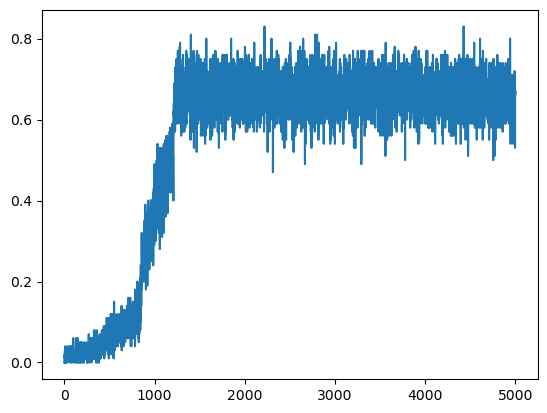

In [145]:
for i in range(n_games):
    done = False
    obs = env.reset()[0]
    score = 0
    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, truncated, info = env.step(action)
        agent.learn(obs, action, reward, obs_)
        agent.decrement_epsilon()
        score += reward
        obs = obs_
        done = done or truncated  # Ensure the loop exits if the episode is truncated

    scores.append(score)
    if i % 100 == 0:
        average = np.mean(scores[-100:])
        win_pct_list.append(average)
        if i % 1000 == 0:
            print('episode', i, 'win pct %.2f' % average, 'epsilon %.2f' % agent.eps)

plt.plot(win_pct_list)
plt.show()